# Оглавление

**Подготовка данных для загрузки в систему**
1. [Подключения к инструментам](#connections)
2. [Предподготовка данных для S3](#preparation_s3)
3. [Переносим данные в clickhouse](#preparation_clickhouse)


**Исследование данных по вопросам менеджеров**
1. [Задача 1](#task1): Одна из стратегических задач классифайда — привлекать продавцов с более низкими ценами. 
Гипотеза команды привлечения заключается в том, что такие пользователи более положительно влияют на количество контактов между продавцами и покупателями.
    - [Загрузка и чистка данных](#task1_data_prep) Этап подготовки данных, поиска аномальных значений
    - [Правда ли, что цены профессионалов больше, чем цены простых пользователей?](#task1_answer)


2. [Задача 2](#task2): Менеджеры хотят понять, насколько быстро продаются в среднем наши объявления. Найдите средний срок продажи (время ухода в архив для объявления). Для этого нужно найти разницу между первым днем появления в live и последним днем (по полю execution_date).

    Также менеджеры хотят найти самые быстро продаваемые и самые медленно продаваемые автомобили, чтобы попробовать рассылать два разных типа пушей первым и вторым. Но им необходимо понимать, много ли объявлений и пользователей можно охватить такой рассылкой. Для менеджеров, если потенциальные рассылки захватывают больше 5% базы и количества листеров, “игра стоит свеч” — значит, мы будем делать рассылки.

    - [Определить топ-5 марок, продающихся быстрее всего, и топ-5 марок, продающихся медленнее всего.](#task2_top5) 
    - [Какую долю объявлений от общей базы составляют эти группы (суммарно ТОП-5 марок, продающихся быстрее всего и ТОП-5 марок, продающихся медленнее всего).](#task2_top5_p1)  
    - [Какую долю пользователей от общего количества листеров составляют эти группы (суммарно ТОП-5 марок, продающихся быстрее всего и ТОП-5 марок, продающихся медленнее всего).](#task2_top5_p2)  


3. [Задача 3](#task3): Менеджеров интересует, увеличилось ли время продажи объявлений в нашем продукте за полгода. Если время продажи растет — это плохо для команды листеров.

    - [Как изменилось время ухода объявлений в архив за полгода (= средний срок продажи )?](#task3_1)
    - [На сколько дней изменилось среднее время ухода в архив в июньской когорте относительно декабрьской когорты?](#task3_2)
    - [По каким маркам время ухода в архив выросло больше всего между когортами?](#task3_3)
    - [У каких пользователей изменение времени продажи выше?](#task3_4)

## Подключения к инструментам <a class="anchor" id="connections"></a>

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.functions import date_format

import os
import socket
import pandas as pd
from pyspark.sql import SparkSession

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
from scipy import stats

import boto3
from botocore.exceptions import NoCredentialsError

In [10]:
## Загружаем данные для последующих подключений
from decouple import Config, RepositoryEnv
import os


DOTENV_FILE = f'{os.getcwd()}/t.env'
env_config = Config(RepositoryEnv(DOTENV_FILE))

click_host = env_config.get('click_host')
click_login = env_config.get('click_login')
click_password = env_config.get('click_password') 


# Указываем credentials и параметры для работы с S3
aws_access_key = env_config.get('aws_access_key')
aws_secret_key = env_config.get('aws_secret_key')
s3_bucket = env_config.get('s3_bucket')
s3_endpoint_url = env_config.get('s3_endpoint_url')

student_directory = 'a-papishvili'
#print(click_host,click_login, click_password )
#print(aws_access_key,aws_secret_key, s3_bucket, s3_endpoint_url )


In [3]:
from clickhouse_driver import Client
import pandas as pd
# Создаем соединение с ClickHouse
client = Client(host=click_host,
                port=9000, 
                user= click_login, 
                password=click_password, 
                database='hardda')

In [4]:
#Spark connection with S3 options

APACHE_MASTER_IP = socket.gethostbyname("apache-spark-master-0.apache-spark-headless.apache-spark.svc.cluster.local")
APACHE_MASTER_URL = f"spark://{APACHE_MASTER_IP}:7077"
POD_IP = os.environ["MY_POD_IP"]
SPARK_APP_NAME = f"spark-{os.environ['HOSTNAME']}"
JARS = """/nfs/env/lib/python3.8/site-packages/pyspark/jars/clickhouse-native-jdbc-shaded-2.6.5.jar, 
/nfs/env/lib/python3.8/site-packages/pyspark/jars/hadoop-aws-3.3.4.jar,
/nfs/env/lib/python3.8/site-packages/pyspark/jars/aws-java-sdk-bundle-1.12.433.jar
"""

MEM = "2048m"
CORES = 1
 
spark = SparkSession.\
        builder.\
        appName(SPARK_APP_NAME).\
        master(APACHE_MASTER_URL).\
        config("spark.executor.memory", MEM).\
        config("spark.jars", JARS).\
        config("spark.executor.cores", CORES).\
        config("spark.driver.host", POD_IP).\
        config("spark.hadoop.fs.s3a.access.key", aws_access_key). \
        config("spark.hadoop.fs.s3a.secret.key", aws_secret_key). \
        config("fs.s3a.endpoint", "https://storage.yandexcloud.net").  \
        config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem"). \
        config("spark.hadoop.fs.s3a.path.style.access", True). \
        config("spark.hadoop.fs.s3a.committer.name", "directory"). \
        config("spark.hadoop.fs.s3a.aws.credentials.provider", "org.apache.hadoop.fs.s3a.SimpleAWSCredentialsProvider"). \
        getOrCreate()

24/02/08 19:42:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [5]:
#S3 connection

# Инициализация клиента S3 с указанием конечной точки
s3 = boto3.client('s3',
                  aws_access_key_id=aws_access_key,
                  aws_secret_access_key=aws_secret_key,
                  endpoint_url=s3_endpoint_url)

Теперь наша задача заключается в том, чтобы реализовать следующую архитектуру:

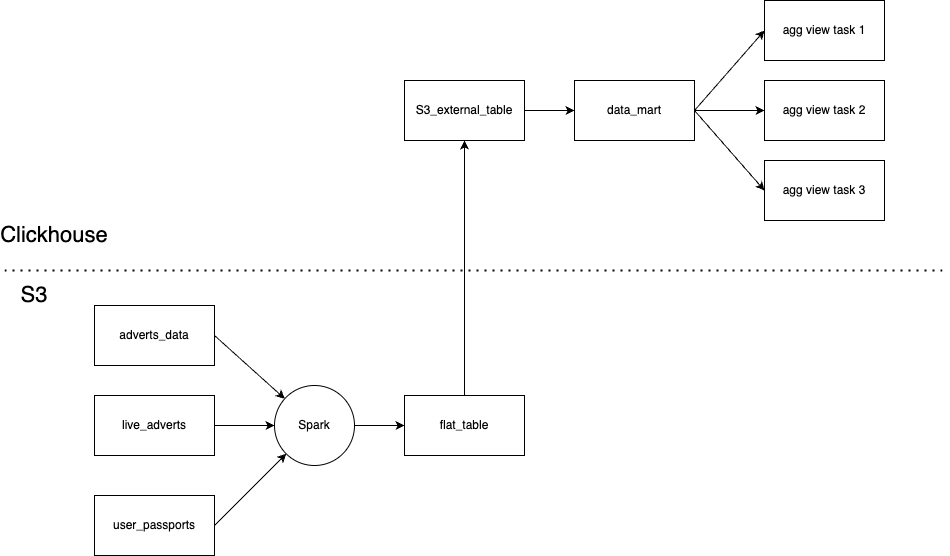

## Предподготовка данных для S3  <a class="anchor" id="preparation_s3"></a>

In [6]:
# Читаем файлы с исходными данными
df_adverts_all = spark.read.parquet(f's3a://{s3_bucket}/shared/adverts_data.parquet')
df_live_adverts = spark.read.parquet(f's3a://{s3_bucket}/shared/live_adverts.parquet')
df_user_passports = spark.read.parquet(f's3a://{s3_bucket}/shared/user_passports.parquet')


# Джойним DF, чтобы сделать широкую витрину для ClickHouse
df_flat = df_live_adverts\
                    .join(df_adverts_all, on=['execution_date', 'advert_id'], how='left') \
                    .join(df_user_passports, df_live_adverts['user_id'] == df_user_passports['global_id'], how='left')

df_flat.printSchema()
df_flat.select(count("execution_date")).show()
df_flat.show(15)

df_flat.createOrReplaceTempView("flat")

24/02/08 19:43:17 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


root
 |-- execution_date: timestamp (nullable = true)
 |-- advert_id: long (nullable = true)
 |-- region: string (nullable = true)
 |-- user_id: long (nullable = true)
 |-- platform: string (nullable = true)
 |-- mark: string (nullable = true)
 |-- model: string (nullable = true)
 |-- price: double (nullable = true)
 |-- year: double (nullable = true)
 |-- fuel: string (nullable = true)
 |-- color: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- body: string (nullable = true)
 |-- country: string (nullable = true)
 |-- global_id: long (nullable = true)
 |-- user_type_name: string (nullable = true)



24/02/08 19:43:37 WARN MemoryStore: Not enough space to cache broadcast_8 in memory! (computed 304.0 MiB so far)
24/02/08 19:43:37 WARN BlockManager: Persisting block broadcast_8 to disk instead.
24/02/08 19:43:39 WARN MemoryStore: Not enough space to cache broadcast_8 in memory! (computed 304.0 MiB so far)


+---------------------+
|count(execution_date)|
+---------------------+
|              2771661|
+---------------------+



+-------------------+---------+------+---------+--------+------+------+---------+------+------+------+------------+-----+-------+---------+--------------+
|     execution_date|advert_id|region|  user_id|platform|  mark| model|    price|  year|  fuel| color|transmission| body|country|global_id|user_type_name|
+-------------------+---------+------+---------+--------+------+------+---------+------+------+------+------------+-----+-------+---------+--------------+
|2021-06-26 00:00:00|137514150|  Омск|124207514| unknown|  null|  null| 114000.0|2014.0|  null|  null|        null| null|   null|124207514|         profi|
|2021-09-20 00:00:00|137514150|  Омск|124207514| unknown|  null|  null| 114000.0|2014.0|  null|  null|        null| null|   null|124207514|         profi|
|2020-12-05 00:00:00|137514150|  Омск|124207514| unknown|  null|  null| 114000.0|2014.0|  null|  null|        null| null|   null|124207514|         profi|
|2021-08-23 00:00:00|137514150|  Омск|124207514| unknown|  null|  null

In [7]:
## формат данных даты
df_flat = df_flat.\
    withColumn("execution_date", col("execution_date").cast("date"))
   #.\ withColumn("dubbles_check", concat(col('execution_date'), lit('_'), col('user_id'), lit('_'),  col('advert_id')))




In [8]:
## быстрая проверка
spark.sql(f"""

SELECT platform, count(*) as rows
          from flat 
          group by platform
          """).show()

24/02/08 19:44:16 WARN MemoryStore: Not enough space to cache broadcast_25 in memory! (computed 304.0 MiB so far)
24/02/08 19:44:16 WARN BlockManager: Persisting block broadcast_25 to disk instead.


24/02/08 19:44:19 WARN MemoryStore: Not enough space to cache broadcast_25 in memory! (computed 304.0 MiB so far)


+--------+-------+
|platform|   rows|
+--------+-------+
| android| 497454|
| desktop| 562156|
| unknown|    785|
|  mobile|  46154|
|     ios|1665112|
+--------+-------+



In [17]:
#сохранение данных на s3
s3_file_name = 'flat_table'
s2_format='parquet'

df_flat.coalesce(1).write.format("parquet").save(f"s3a://{s3_bucket}/{student_directory}/{s3_file_name}", mode='overwrite')


# Получение списка объектов в S3-бакете и нужной директории
response = s3.list_objects_v2(Bucket=s3_bucket, Prefix = 'a-papishvili/')
file_name = []

# Вывод списка объектов
if 'Contents' in response:
    for obj in response['Contents']:
        print(f"- {obj['Key']}")
        if 'flat_table' in obj['Key']:
            
            file_name.append(obj['Key'])
else:
    print(f"No objects found in bucket '{s3_bucket}'")


- a-papishvili/_SUCCESS
- a-papishvili/flat_tab/_SUCCESS
- a-papishvili/flat_tab/part-00000-a1a311ec-de9c-4991-8c51-6da65fedc6ad-c000.snappy.parquet
- a-papishvili/flat_table/_SUCCESS
- a-papishvili/flat_table/part-00000-28d28a23-14f5-45cd-9e43-aa55be07f01e-c000.snappy.parquet
- a-papishvili/orders_test_write/_SUCCESS
- a-papishvili/orders_test_write/part-00000-c0284323-716b-4d94-9ccb-aa5ded824d9d-c000.csv
- a-papishvili/part-00000-766faecf-bbef-4eaf-ac51-fa20503c5c6a-c000.snappy.parquet


## Переносим данные в clickhouse  <a class="anchor" id="preparation_clickhouse"></a>

In [18]:
# Таблица с движком S3, которая смотрит на сформированный ранее плоский файл. 
result = client.execute("""
DROP TABLE IF EXISTS hardda_student_data.prj_s3_ext_a_papishvili;
""")


result = client.execute(f"""                        

create table hardda_student_data.prj_s3_ext_a_papishvili
    (
execution_date Date,
advert_id  UInt64,
region LowCardinality(String),
user_id UInt64,
platform LowCardinality(String),
mark LowCardinality(Nullable(String)),
model LowCardinality(Nullable(String)),
price Nullable(Float32),
year Nullable(UInt16),
fuel LowCardinality(Nullable(String)),
color LowCardinality(Nullable(String)),
transmission LowCardinality(Nullable(String)),
body LowCardinality(Nullable(String)),
country LowCardinality(Nullable(String)), 
global_id Nullable(UInt64),
user_type_name LowCardinality(Nullable(String)) 
     )
	
ENGINE = S3('{s3_endpoint_url}/{s3_bucket}/{file_name[1]}', 'Parquet')

PARTITION BY platform
ORDER BY (platform) 
PRIMARY KEY (platform) 
    
""")


In [19]:
## проверяем S3 данные

result = client.execute(f"""SELECT * 
                            FROM hardda_student_data.prj_s3_ext_a_papishvili
                            limit 5
                            """)

pd.DataFrame(result, columns=df_flat.columns)

,execution_date,advert_id,region,user_id,platform,mark,model,price,year,fuel,color,transmission,body,country,global_id,user_type_name
0,2020-12-25,236092185,Москва,123456986,ios,None,None,NaN,None,None,None,None,None,None,123456986,simple_user
1,2020-12-31,236092185,Москва,123456986,ios,None,None,NaN,None,None,None,None,None,None,123456986,simple_user
2,2021-01-07,236092185,Москва,123456986,ios,None,None,NaN,None,None,None,None,None,None,123456986,simple_user
3,2021-01-24,236092185,Москва,123456986,ios,None,None,NaN,None,None,None,None,None,None,123456986,simple_user
4,2021-01-25,256283734,Москва,123456986,ios,None,None,2000.0,None,None,None,None,None,None,123456986,simple_user


In [20]:
result = client.execute("""SELECT partition_key, primary_key, sorting_key
                        FROM system.tables WHERE database='hardda_student_data' and table = 'prj_s3_ext_a_papishvili'
                        """)

result

[('', '', '')]

In [21]:
# Создаем заготовку mergeTree

result = client.execute("""
DROP TABLE IF EXISTS hardda_student_data.prj_main_a_papishvili;
""")

result = client.execute(f"""                        

create table hardda_student_data.prj_main_a_papishvili
    (
execution_date Date,
advert_id  UInt64,
region LowCardinality(String),
user_id UInt64,
platform LowCardinality(String),
mark LowCardinality(Nullable(String)),
model LowCardinality(Nullable(String)),
price Nullable(Float32),
year Nullable(UInt16),
fuel LowCardinality(Nullable(String)),
color LowCardinality(Nullable(String)),
transmission LowCardinality(Nullable(String)),
body LowCardinality(Nullable(String)),
country LowCardinality(Nullable(String)), 
global_id Nullable(UInt64),
user_type_name LowCardinality(Nullable(String)) 
     )
    ENGINE = MergeTree 
 PARTITION BY platform
ORDER BY (execution_date, advert_id) 
PRIMARY KEY (execution_date, advert_id) 
SETTINGS index_granularity = 8192 
""")


result = client.execute("""SELECT *
                           FROM hardda_student_data.prj_main_a_papishvili
                           limit 1
                       """)

pd.DataFrame(result, columns=df_flat.columns)

,execution_date,advert_id,region,user_id,platform,mark,model,price,year,fuel,color,transmission,body,country,global_id,user_type_name


#### Подготавливаем МП для решения задач

In [22]:
# Materialized View 1

result = client.execute("""DROP TABLE IF EXISTS hardda_student_data.prj_main_a_papishvili_agg_view_1;""")
\

result = client.execute(f"""                        
CREATE MATERIALIZED VIEW hardda_student_data.prj_main_a_papishvili_agg_view_1
    (execution_date Date,
    platform LowCardinality(String),
    user_type_name LowCardinality(Nullable(String)),    
	
    min_price SimpleAggregateFunction(min,  Nullable(Float32)),
    price_quantiles  AggregateFunction(quantiles(0.25, 0.75),  Nullable(Float32)),
    price_quantiles_ex  AggregateFunction(quantilesExactExclusive(0.25, 0.75),  Nullable(Float32)),
    average_price AggregateFunction(avgOrNull,  Nullable(Float32)),
    max_price SimpleAggregateFunction(max,  Nullable(Float32))
     )
	 
ENGINE = AggregatingMergeTree
PARTITION BY platform
ORDER BY (execution_date, platform, user_type_name) 

AS SELECT
    execution_date, platform, user_type_name,  
    min(price) as min_price,
    quantilesState(0.25, 0.75)(price) as price_quantiles,
    quantilesExactExclusiveState(0.25, 0.75)(price) as price_quantiles_ex,
    avgOrNullState(price) as average_price,
    max(price) as max_price

FROM hardda_student_data.prj_main_a_papishvili
WHERE price IS NOT NULL
GROUP BY execution_date, platform, user_type_name
""")


In [23]:
# Materialized View 2

result = client.execute("""DROP TABLE IF EXISTS hardda_student_data.prj_main_a_papishvili_agg_view_2;""")

result = client.execute(f"""                        
CREATE MATERIALIZED VIEW hardda_student_data.prj_main_a_papishvili_agg_view_2
    (advert_id UInt64,
	user_id UInt64,
	mark LowCardinality(Nullable(String)),
	model LowCardinality(Nullable(String)),

    min_date SimpleAggregateFunction(min,  Date),
    max_date SimpleAggregateFunction(max,  Date),
	
    min_price SimpleAggregateFunction(min,  Nullable(Float32)),
    price_quantiles  AggregateFunction(quantiles(0.5),  Nullable(Float32)),
    price_quantiles_ex  AggregateFunction(quantilesExactExclusive(0.5),  Nullable(Float32)),
    average_price AggregateFunction(avgOrNull,  Nullable(Float32)),
    max_price SimpleAggregateFunction(max,  Nullable(Float32))
     )
	 
ENGINE = AggregatingMergeTree
PARTITION BY mark
ORDER BY (advert_id, user_id) 

AS SELECT
    advert_id, user_id, mark, model, 
    min(execution_date) as min_date, 
    max(execution_date) as max_date, 
	
    min(price) as min_price,
    quantilesState(0.5)(price) as price_quantiles,
    quantilesExactExclusiveState(0.5)(price) as price_quantiles_ex,
    avgOrNullState(price) as average_price,
    max(price) as max_price

FROM hardda_student_data.prj_main_a_papishvili
WHERE price IS NOT NULL
GROUP BY advert_id, user_id, mark, model

""")


In [24]:
# Materialized View 3

result = client.execute("""DROP TABLE IF EXISTS hardda_student_data.prj_main_a_papishvili_agg_view_3;""")

result = client.execute(f"""                        
CREATE MATERIALIZED VIEW hardda_student_data.prj_main_a_papishvili_agg_view_3
    (advert_id UInt64,
    user_type_name LowCardinality(Nullable(String)),
    mark LowCardinality(Nullable(String)),

    min_date SimpleAggregateFunction(min,  Date),
    max_date SimpleAggregateFunction(max,  Date),
    
    min_price SimpleAggregateFunction(min,  Nullable(Float32)),
    price_quantiles  AggregateFunction(quantiles(0.5),  Nullable(Float32)),
    price_quantiles_ex  AggregateFunction(quantilesExactExclusive(0.5),  Nullable(Float32)),
    average_price AggregateFunction(avgOrNull,  Nullable(Float32)),
    max_price SimpleAggregateFunction(max,  Nullable(Float32))
     )
     
ENGINE = AggregatingMergeTree
PARTITION BY mark
ORDER BY (advert_id) 

AS SELECT
    advert_id, user_type_name, mark, 
    min(execution_date) as min_date, 
    max(execution_date) as max_date, 
    
    min(price) as min_price,
    quantilesState(0.5)(price) as price_quantiles,
    quantilesExactExclusiveState(0.5)(price) as price_quantiles_ex,
    avgOrNullState(price) as average_price,
    max(price) as max_price

FROM hardda_student_data.prj_main_a_papishvili
GROUP BY advert_id, user_type_name, mark

""")

In [25]:
## заполняем MergeTree данными из s3

result = client.execute(f"""INSERT INTO hardda_student_data.prj_main_a_papishvili 
                            SELECT * 
                            FROM hardda_student_data.prj_s3_ext_a_papishvili
                            """)

## проверяем MergeTree данные
result = client.execute(f"""SELECT * 
                            FROM hardda_student_data.prj_main_a_papishvili 
                            limit 10
                            """)

pd.DataFrame(result, columns=df_flat.columns)


,execution_date,advert_id,region,user_id,platform,mark,model,price,year,fuel,color,transmission,body,country,global_id,user_type_name
0,2020-11-12,151579689,Сочи,124045733,unknown,None,None,2000.0,NaN,None,None,None,None,None,124045733,profi
1,2020-11-14,130582517,Сочи,123464584,unknown,None,None,NaN,NaN,None,None,None,None,None,123464584,simple_user
2,2020-11-14,131290038,Казань,123661493,unknown,None,None,NaN,NaN,None,None,None,None,None,123661493,simple_user
3,2020-11-14,131543541,Казань,123661493,unknown,None,None,NaN,NaN,None,None,None,None,None,123661493,simple_user
4,2020-11-14,137514150,Омск,124207514,unknown,None,None,114000.0,2014.0,None,None,None,None,None,124207514,profi
5,2020-11-14,145314141,Уфа,124243239,unknown,None,None,NaN,NaN,None,None,None,None,None,124243239,simple_user
6,2020-11-14,157216679,Сочи,126767248,unknown,None,None,NaN,NaN,None,None,None,None,None,126767248,simple_user
7,2020-11-15,127593536,Омск,123628037,unknown,None,None,NaN,NaN,None,None,None,None,None,123628037,profi
8,2020-11-15,131647492,Пермь,123750125,unknown,None,None,NaN,NaN,None,None,None,None,None,123750125,profi
9,2020-11-15,157216679,Сочи,126767248,unknown,None,None,NaN,NaN,None,None,None,None,None,126767248,simple_user


# Задача 1 <a class="anchor" id="task1"></a>
Одна из стратегических задач классифайда — привлекать продавцов с более низкими ценами. 
Гипотеза команды привлечения заключается в том, что такие пользователи более положительно влияют на количество контактов между продавцами и покупателями.

- Правда ли, что цены профессионалов больше, чем цены простых пользователей?

### Загрузка и чистка данных <a class="anchor" id="task1_data_prep"></a>

In [26]:
##ПРоверяем МП1
result = client.execute(f"""
SELECT
    execution_date, platform, user_type_name,  
    
    min(min_price) as min_price,
    quantilesMerge(0.25, 0.75)(price_quantiles) as price_quantiles,
    quantilesExactExclusiveMerge(0.25, 0.75)(price_quantiles_ex) as price_quantiles_ex,
    avgOrNullMerge(average_price) as average_price,
    max(max_price) as max_price

FROM hardda_student_data.prj_main_a_papishvili_agg_view_1
WHERE user_type_name in ('profi', 'simple_user') 
GROUP BY execution_date, platform, user_type_name
""")

df1 = pd.DataFrame(result, columns=['execution_date', 'platform', 'user_type_name', 'min_price', 'price_quantiles', 'price_quantiles_ex', 'average_price', 'max_price'])
df1.head()

,execution_date,platform,user_type_name,min_price,price_quantiles,price_quantiles_ex,average_price,max_price
0,2021-09-24,unknown,simple_user,2800000.0,"[2800000.0, 2800000.0]","[2800000.0, 2800000.0]",2.800000e+06,2800000.0
1,2021-03-25,mobile,simple_user,0.0,"[1000000.0, 3000000.0]","[4000000.0, 0.0]",2.000000e+06,4000000.0
2,2021-04-02,desktop,profi,0.0,"[4000.0, 56000.0]","[4000.0, 56000.0]",4.735258e+05,9218195.0
3,2021-05-06,ios,profi,0.0,"[3000.0, 20000.0]","[3000.0, 20000.0]",5.333361e+04,12000000.0
4,2021-01-18,desktop,simple_user,0.0,"[4750.0, 18250.0]","[4250.0, 18750.0]",2.180199e+05,5120000.0


In [27]:
# array into columns
df_expanded = df1['price_quantiles'].apply(pd.Series)
df_expanded.columns= ['price_quantiles25','price_quantiles75']

# Объедините новые колонки с исходным DataFrame
df1 = pd.concat([df1, df_expanded], axis=1)
df1['average_price']=df1['average_price'].round()
df1['price_quantiles25']=df1['price_quantiles25'].round()
df1['price_quantiles75']=df1['price_quantiles75'].round()

df1.head()

,execution_date,platform,user_type_name,min_price,price_quantiles,price_quantiles_ex,average_price,max_price,price_quantiles25,price_quantiles75
0,2021-09-24,unknown,simple_user,2800000.0,"[2800000.0, 2800000.0]","[2800000.0, 2800000.0]",2800000.0,2800000.0,2800000.0,2800000.0
1,2021-03-25,mobile,simple_user,0.0,"[1000000.0, 3000000.0]","[4000000.0, 0.0]",2000000.0,4000000.0,1000000.0,3000000.0
2,2021-04-02,desktop,profi,0.0,"[4000.0, 56000.0]","[4000.0, 56000.0]",473526.0,9218195.0,4000.0,56000.0
3,2021-05-06,ios,profi,0.0,"[3000.0, 20000.0]","[3000.0, 20000.0]",53334.0,12000000.0,3000.0,20000.0
4,2021-01-18,desktop,simple_user,0.0,"[4750.0, 18250.0]","[4250.0, 18750.0]",218020.0,5120000.0,4750.0,18250.0


В первую очередь ознакомимся с данными, чтобы понять нет ли аномальных значений. Начнем со сводной таблицы, чтобы лучше ознакомиться со спецификой данных по группам

In [28]:
df1.groupby('user_type_name').agg({
    'average_price': ['mean', 'min', 'max'],
    'price_quantiles25': ['mean', 'min'],
    'price_quantiles75': ['mean', 'min', 'max']
}).reset_index()

user_type_name average_price                    price_quantiles25       \
                          mean     min        max              mean  min   
0          profi  1.496257e+05  1962.0  3224288.0      10320.228553  0.0   
1    simple_user  1.083054e+06     0.0  5100000.0     231517.181695  0.0   

  price_quantiles75                     
               mean     min        max  
0      6.556219e+04  1000.0  3267500.0  
1      1.279625e+06     0.0  5100000.0

In [29]:
x1 = df1.query("user_type_name=='simple_user' and average_price==0" ).shape[0]
xn = df1.query("user_type_name=='simple_user'" ).shape[0]
print (x1, xn, x1/xn*100)

48 1475 3.2542372881355934


Исключим данные с average_price=0 для группы пользователей user_type_name=='simple_user'. Нулевая цена скорее всего являлась ошибкой ввода пользователей или недобросовестными объявлениями о продаже.

Исключение кейсов с average_price=0 на 3% сократит долю кейсов в группе simple_user. Однако эту потерю данных можно считать несущественной, в то время как качество данных улучшится

In [30]:
df1 = df1.query("(user_type_name=='simple_user' and average_price>0) or (user_type_name=='profi')")

df1.groupby('user_type_name').agg({
    'average_price': ['mean', 'min', 'max'],
    'price_quantiles25': ['mean', 'min'],
    'price_quantiles75': ['mean', 'min', 'max']
}).reset_index()

user_type_name average_price                    price_quantiles25       \
                          mean     min        max              mean  min   
0          profi  1.496257e+05  1962.0  3224288.0      10320.228553  0.0   
1    simple_user  1.119485e+06     7.0  5100000.0     239304.725298  0.0   

  price_quantiles75                     
               mean     min        max  
0      6.556219e+04  1000.0  3267500.0  
1      1.322668e+06    10.0  5100000.0

Исследуем распределение метрика "Средняя стоимость автомобиля" с помощью гистограммы:

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


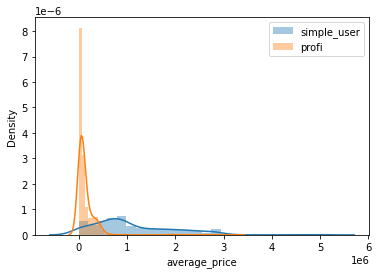

In [31]:
sns.distplot(df1.query("user_type_name=='simple_user'").average_price.dropna(), label='simple_user')
sns.distplot(df1.query("user_type_name=='profi'").average_price.dropna(), label='profi')
plt.legend()
plt.show()

Из графика распределения можно увидеть, что:

- средняя цена в группе profi ниже, чем в группе simple_user
- дисперсия цены в группе simple_user выше, чем в группе profi
- метрика "Средняя стоимость автомобиля", как многие экономические и финансовые данные, имеет логнормальное распределение с перекосом влево. Такое распределение достаточно неудобно для проверки стат гипотез.

Преобразуем метрику в натуральный логарифм "Средней стоимости автомаобиля". Это позволит нам использовать статистические тесты для проверки гипотезы о том, что действительно ли средняя цена в группе profi ниже, чем в группе simple_user с точки зрения статистики


/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


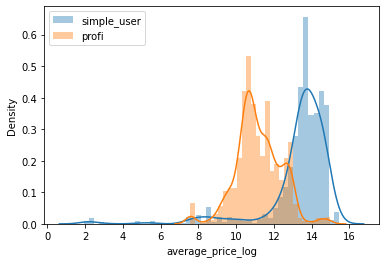

In [32]:
df1['average_price_log'] = np.log(df1['average_price'])
sns.distplot(df1.query("user_type_name=='simple_user'").average_price_log.dropna(), label='simple_user')
sns.distplot(df1.query("user_type_name=='profi'").average_price_log.dropna(), label='profi')
plt.legend()
plt.show()

На новой гистограмме распределений мы можем наблюдать, что логарифмирование помогло нам получить данные нормального распредления.
В данном случае мы пренебрежем выбросами, которые наблюдаются слева, т.к. информация о слишком низких ценах также существенна для нас. 

### Правда ли, что цены профессионалов больше, чем цены простых пользователей? <a class="anchor" id="task1_answer"></a>

Менеджеры хотят понять 
Для проверки гипотезы используем статистический критерий t-test. Сформулируем статистические гипотезы:
- H0: средняя цена продажи авто не различается по типу пользователя
- H1: средняя цена продажи авто различается по типу пользователя

In [33]:
# задаем уровень значимости
alpha = 0.05

#проводим тест
simple_u = df1[df1['user_type_name'] == 'simple_user']['average_price_log']
profi_u = df1[df1['user_type_name'] == 'profi']['average_price_log']

p_value=stats.ttest_ind( simple_u, profi_u, equal_var=True)

# анализируем результат
if float(p_value[1]) < alpha:
    print('Отвергаем нулевую гипотезу: средняя цена продажи авто различается по типу пользователя')
else:
    print('Не отвергаем нулевую гипотезу: средняя цена продажи авто не различается по типу пользователя')

Отвергаем нулевую гипотезу: средняя цена продажи авто различается по типу пользователя


Какие именно различия наблюдаются между группами:

In [34]:
print(  'Вывод: У простых пользователей средняя цена продажи авто выше, чем у профи на '
      + str(df1[df1['user_type_name'] == 'simple_user']['average_price'].mean().round() -  df1[df1['user_type_name'] == 'profi']['average_price'].mean().round()) + '\n',  
     )

Вывод: У простых пользователей средняя цена продажи авто выше, чем у профи на 969859.0



# Задание 2 <a class="anchor" id="task2"></a>
Менеджеры хотят понять, насколько быстро продаются в среднем наши объявления. Найдите средний срок продажи (время ухода в архив для объявления). Для этого нужно найти разницу между первым днем появления в live и последним днем (по полю execution_date).

Также менеджеры хотят найти самые быстро продаваемые и самые медленно продаваемые автомобили, чтобы попробовать рассылать два разных типа пушей первым и вторым. Но им необходимо понимать, много ли объявлений и пользователей можно охватить такой рассылкой. Для менеджеров, если потенциальные рассылки захватывают больше 5% базы и количества листеров, “игра стоит свеч” — значит, мы будем делать рассылки.

Вопросы:
- Определить топ-5 марок, продающихся быстрее всего, и топ-5 марок, продающихся медленнее всего. 
- Какую долю объявлений от общей базы составляют эти группы (суммарно ТОП-5 марок, продающихся быстрее всего и ТОП-5 марок, продающихся медленнее всего).
- Какую долю пользователей от общего количества листеров составляют эти группы (суммарно ТОП-5 марок, продающихся быстрее всего и ТОП-5 марок, продающихся медленнее всего).

In [35]:
##ПРоверяем МП2
result = client.execute(f"""
SELECT
    advert_id, user_id, mark, model, 
	min(min_date) as min_date, 
    max(max_date) as max_date, 
    min(min_price) as min_price,
    quantilesMerge(0.5)(price_quantiles) as price_quantiles,
    quantilesExactExclusiveMerge(0.5)(price_quantiles_ex) as price_quantiles_ex,
    avgOrNullMerge(average_price) as average_price,
    max(max_price) as max_price 
FROM hardda_student_data.prj_main_a_papishvili_agg_view_2
GROUP BY advert_id, user_id, mark, model
""")

df2 = pd.DataFrame(result, columns=['advert_id', 'user_id', 'mark', 'model', 'min_date','max_date','min_price', 'price_quantiles',  'price_quantiles_ex', 'average_price', 'max_price'])
df2 = df2.query("average_price>0") # Исключаем объявления с 0 ценой, т.к. предполагаем, что это ошибка ввода
df2['days_for_sale'] = (df2['max_date'] - df2['min_date']).dt.days
df2.head()

,advert_id,user_id,mark,model,min_date,max_date,min_price,price_quantiles,price_quantiles_ex,average_price,max_price,days_for_sale
0,262535435,123696103,Toyota,Estima,2021-05-17,2021-11-05,1600000.0,[1600000.0],[1600000.0],1650000.0,1800000.0,172
1,270205085,146140025,Toyota,RAV4,2021-11-07,2021-11-11,2730000.0,[2730000.0],[2730000.0],2730000.0,2730000.0,4
2,268819749,145726328,None,None,2021-10-04,2021-11-09,2000.0,[2000.0],[2000.0],2000.0,2000.0,36
3,168398307,123591452,None,None,2020-11-12,2021-11-05,1000.0,[1000.0],[1000.0],1000.0,1000.0,358
4,236503610,123477337,None,None,2020-11-14,2021-11-08,3400.0,[3400.0],[3400.0],3400.0,3400.0,359


### Топ-5 марок, продающихся быстрее всего, и топ-5 марок, продающихся медленнее всего. <a class="anchor" id="task2_top5"></a>

In [36]:
df2_marks=df2.groupby('mark', as_index=False)\
    .agg({'days_for_sale':'mean'})\
    .sort_values('days_for_sale', ascending=True).reset_index()

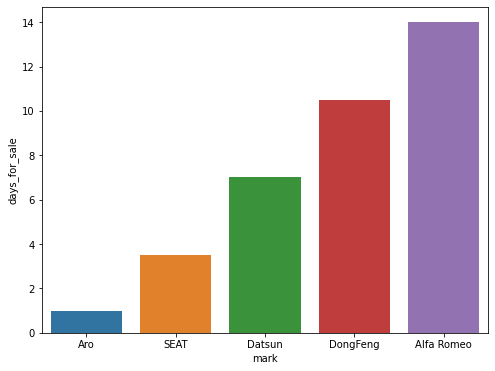

In [37]:
# топ-5 марок, продающихся быстрее всего
plt.figure(figsize=(8, 6))
sns.barplot(data=df2_marks.head(5), x='mark', y='days_for_sale')
plt.show()

In [38]:
#Доля продаж топ-5 марок, продающихся быстрее всего

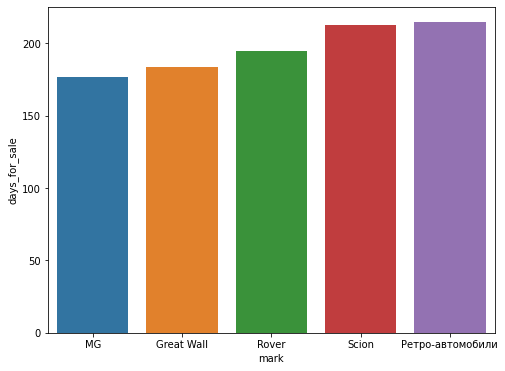

In [39]:
# топ-5 марок, продающихся медленнее всего
plt.figure(figsize=(8, 6))
sns.barplot(data=df2_marks.tail(5), x='mark', y='days_for_sale')
plt.show()

#### Какую долю объявлений от общей базы составляют эти группы (суммарно ТОП-5 марок, продающихся быстрее всего и ТОП-5 марок, продающихся медленнее всего).  <a class="anchor" id="task2_top5_p1"></a>

In [40]:
top5=df2_marks.iloc[0:5,1].tolist()
bot5=df2_marks.iloc[-5:,1].tolist()
df2['top5_flag']=df2['mark'].apply(lambda x: 1 if x in top5 else 0)
df2['bot5_flag']=df2['mark'].apply(lambda x: 1 if x in bot5 else 0)

df2['flag_mark']=df2['bot5_flag']+df2['top5_flag']

In [41]:
df2_marks=df2.groupby(['advert_id', 'flag_mark'], as_index=False).agg({'user_id':'count'})
print("Вывод:" ,(df2_marks['flag_mark'].mean()*100).round(2), "%")

Вывод: 0.03 %


#### Какую долю пользователей от общего количества листеров составляют эти группы (суммарно ТОП-5 марок, продающихся быстрее всего и ТОП-5 марок, продающихся медленнее всего).
 <a class="anchor" id="task2_top5_p2"></a>

In [42]:
df2_marks=df2.groupby(['user_id', 'flag_mark'], as_index=False).agg({'user_id':'count'})
print("Вывод:" ,(df2_marks['flag_mark'].mean()*100).round(2), "%")

Вывод: 0.18 %


# Задание 3 <a class="anchor" id="task3"></a>
Менеджеров интересует, увеличилось ли время продажи объявлений в нашем продукте за полгода. Если время продажи растет — это плохо для команды листеров.

- Как изменилось время ухода объявлений в архив за полгода (= средний срок продажи )?
- На сколько дней изменилось среднее время ухода в архив в июньской когорте относительно декабрьской когорты?
- По каким маркам время ухода в архив выросло больше всего между когортами?
- У каких пользователей изменение времени продажи выше?

In [43]:
##Проверяем МП3
result = client.execute(f"""
select * , max_date - min_date as days_for_sale,
case when min_date BETWEEN '2020-12-01' AND '2020-12-31' then 'group1_dec'
when  min_date  BETWEEN '2021-06-01' AND '2021-06-30' then 'group2_jun'
else 'other' end as cogort

from (
        SELECT
            advert_id, user_type_name, mark, 
            min(min_date) as min_date, 
            max(max_date) as max_date, 
            min(min_price) as min_price,
            quantilesMerge(0.5)(price_quantiles) as price_quantiles,
            quantilesExactExclusiveMerge(0.5)(price_quantiles_ex) as price_quantiles_ex,
            avgOrNullMerge(average_price) as average_price,
            max(max_price) as max_price 

        FROM hardda_student_data.prj_main_a_papishvili_agg_view_3
        group by  advert_id, user_type_name, mark
    ) as a
where cogort in('group1_dec', 'group2_jun')
""")


df3 = pd.DataFrame(result, columns=['advert_id', 'user_type_name', 'mark', 'min_date','max_date','min_price',
                                    'price_quantiles',  'price_quantiles_ex', 'average_price', 'max_price', 
                                    'days_for_sale', 'cogort'])
#df3['days_for_sale'] = (df3['max_date'] - df3['min_date']).dt.days
df3 = df3.query("average_price>0") # Исключаем объявления с 0 ценой, т.к. предполагаем, что это ошибка ввода
df3.head()

,advert_id,user_type_name,mark,min_date,max_date,min_price,price_quantiles,price_quantiles_ex,average_price,max_price,days_for_sale,cogort
0,263812074,profi,None,2021-06-15,2021-11-07,6000.0,[6000.0],[6000.0],6000.000000,6000.0,145,group2_jun
1,255503412,profi,None,2020-12-27,2021-11-08,3000.0,[3000.0],[3000.0],3000.000000,3000.0,316,group1_dec
2,264000051,simple_user,None,2021-06-19,2021-10-22,800000.0,[839900.0],[839900.0],821530.769231,840000.0,125,group2_jun
3,255521566,profi,None,2020-12-27,2021-11-07,2000.0,[2000.0],[2000.0],2000.000000,2000.0,315,group1_dec
4,254495033,profi,None,2020-12-06,2021-11-07,1000.0,[1000.0],[1000.0],1000.000000,1000.0,336,group1_dec


#### Как изменилось время ухода объявлений в архив за полгода (= средний срок продажи)? <a class="anchor" id="task3_1"></a>

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


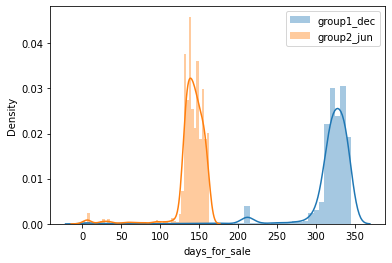

In [44]:
sns.distplot(df3.query("cogort=='group1_dec'").days_for_sale.dropna(), label='group1_dec')
sns.distplot(df3.query("cogort=='group2_jun'").days_for_sale.dropna(), label='group2_jun')
plt.legend()
plt.show()

График распределения дает нам основание предположить,что скорость продаж в когорте Июня выше, чем в когорте Декабря. Проверим гипотезу статистически.

Исходя из графика выше, мы можем считать, что в данном случае метрика days_for_sale имеет нормальное распределение с выбросами в сторону 0. Однако для нас эта информация является важной, поэтому доп анализ для исключения выбросов проводиться не будет.

Сформулируем стат гипотезы:
- **H0**: Скорость продаж в двух когортах одинаковая
- **H1**: Скорость продаж в двух когортах различается

In [45]:
c1 = df3.query("cogort=='group1_dec'")[['days_for_sale']]
c2 = df3.query("cogort=='group2_jun'")[['days_for_sale']]

# задаем группы
alpha = 0.05

# проводим тест
p_value=stats.ttest_ind( c1, c2,equal_var=True )

# анализируем результат
if float(p_value[1]) < alpha:
    print('Отвергаем нулевую гипотезу: Скорость продаж в двух когортах различается')
else:
    print('Не отвергаем нулевую гипотезу: Скорость продаж в двух когортах одинаковая')

Отвергаем нулевую гипотезу: Скорость продаж в двух когортах различается


#### На сколько дней изменилось среднее время ухода в архив в июньской когорте относительно декабрьской когорты <a class="anchor" id="task3_2"></a>

In [46]:
print("Скорость продаж в когорте июня выше скорости продаж в когорте декабря на" + str((c1.mean()-c2.mean()).round()) + "дней")

Скорость продаж в когорте июня выше скорости продаж в когорте декабря наdays_for_sale    177.0
dtype: float64дней


#### По каким маркам время ухода в архив выросло больше всего между когортами? <a class="anchor" id="task3_3"></a>

In [47]:
marks = df3['mark'].unique().tolist()
svod=[]

for i  in range(0,len(marks)):
    g1 = df3[(df3['mark'] == marks[i]) & (df3['cogort'] == 'group1_dec')]['days_for_sale']
    #print(marks[i])
    g2 = df3[(df3['mark'] == marks[i]) & (df3['cogort'] == 'group2_jun')]['days_for_sale']
    a = stats.ttest_ind( g1, g2, equal_var=True)
    diff = g1.mean()-g2.mean()
    
    #пишем в таблицу
    #if float(a[1])<0.05:
    row=[marks[i],  g1.mean() , g2.mean(),  diff, float(a[1])]
    svod.append(row)

/tmp/ipykernel_707/905478945.py:8: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  a = stats.ttest_ind( g1, g2, equal_var=True)
/opt/conda/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/opt/conda/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


In [48]:
svod_marks = pd.DataFrame(svod, columns = ['mark', 'Group 1',  'Group 2', 'diff', 'test']) 

In [49]:
svod_marks.loc[svod_marks['diff'].idxmin()]

mark       Renault
Group 1       34.0
Group 2      141.0
diff        -107.0
test           NaN
Name: 25, dtype: object

#### У каких пользователей изменение времени продажи выше? <a class="anchor" id="task3_4"></a>

In [50]:
marks = df3['user_type_name'].unique().tolist()
svod=[]

for i  in range(0,len(marks)):
    g1 = df3[(df3['user_type_name'] == marks[i]) & (df3['cogort'] == 'group1_dec')]['days_for_sale']
    #print(marks[i])
    g2 = df3[(df3['user_type_name'] == marks[i]) & (df3['cogort'] == 'group2_jun')]['days_for_sale']
    a = stats.ttest_ind( g1, g2, equal_var=True)
    diff = g1.mean()-g2.mean()
    
    #пишем в таблицу
    #if float(a[1])<0.05:
    row=[marks[i],  g1.mean() , g2.mean(),  diff, float(a[1])]
    svod.append(row)

In [51]:
svod_marks = pd.DataFrame(svod, columns = ['user_type_name', 'group1_dec',  'group2_jun', 'diff', 'test']) 
svod_marks

,user_type_name,group1_dec,group2_jun,diff,test
0,profi,320.598974,142.730831,177.868143,0.000000e+00
1,simple_user,283.121107,124.947581,158.173527,1.684460e-156
2,None,NaN,NaN,NaN,NaN
3,avtosalon,NaN,148.000000,NaN,NaN


Вывод: Среди профи наблюдается самое высокое изменение продаж.

In [52]:
############ finale
spark.stop()
client.disconnect_connection()